In [159]:
import json
import numpy as np
node_dict = {}
with open("san_francisco_censustracts.json") as jsondata:
    d = json.load(jsondata)
    for feature in d["features"]:
        if feature["properties"]["DISPLAY_NAME"] == "100 Campus Drive, Stanford":
            print("Stanford", feature["properties"]["MOVEMENT_ID"])
        if feature["properties"]["DISPLAY_NAME"] == "700 Meder Street, Santa Cruz":
            print("UCSC", feature["properties"]["MOVEMENT_ID"])
        data = feature["geometry"]["coordinates"][0][0]
        c1= []
        c2 = []
        for d in data:
            c1.append(d[0])
            c2.append(d[1])
        node_dict[int(feature["properties"]["MOVEMENT_ID"])] = [np.mean(c1), np.mean(c2)]

UCSC 1968
Stanford 2607


In [160]:
print(node_dict[1968])
print(node_dict[2607])

[-122.0645618108108, 36.97416881081081]
[-122.17598222222222, 37.42968588888889]


In [161]:
from scipy.spatial import Delaunay
import numpy as np
# print(node_dict.values())

In [162]:
# stanford_nodes = stanford_nodes[0][0]
# ucsc_nodes = ucsc_nodes[0][0]

# nodes = []
# for node in stanford_nodes:
#     nodes.append(node)
# for node in ucsc_nodes:
#     nodes.append(node)
points = np.array(list(node_dict.values()))

In [163]:
print(len(points))

2710


In [164]:
print(points[1967])
print(points[2606])

[-122.06456181   36.97416881]
[-122.17598222   37.42968589]


In [165]:
tri = Delaunay(points)

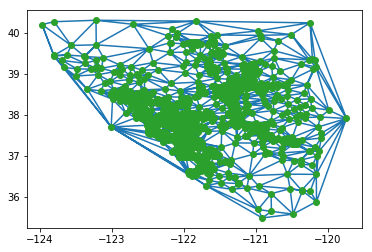

In [166]:
import matplotlib.pyplot as plt
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

In [167]:
print(tri.vertices[1])

[204 247 629]


In [168]:
edges = set() 
for n in range(tri.nsimplex): 
    edge = ([tri.vertices[n,0], tri.vertices[n,1]]) 
    if edge[0] in node_dict and edge[1] in node_dict:
        edges.add((edge[0], edge[1])) 
    edge = ([tri.vertices[n,0], tri.vertices[n,2]]) 
    if edge[0] in node_dict and edge[1] in node_dict:
        edges.add((edge[0], edge[1])) 
    edge = ([tri.vertices[n,1], tri.vertices[n,2]])     
    if edge[0] in node_dict and edge[1] in node_dict:
        edges.add((edge[0], edge[1])) 
# print(edges)

In [170]:
import csv
speed_dict = {}
with open('san_francisco-censustracts-2017-4-All-MonthlyAggregate.csv') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    next(csvReader, None)
    for row in csvReader:
        if row[2] == "12":
            keypair = (int(row[0]) - 1, int(row[1]) - 1)
            if keypair in speed_dict:
                speed_dict[keypair].append(float(row[3]))
            else:
                speed_dict[keypair] = [float(row[3])]
            keypair = (int(row[1]) - 1, int(row[0]) - 1)
            if keypair in speed_dict:
                speed_dict[keypair].append(float(row[3]))
            else:
                speed_dict[keypair] = [float(row[3])]


In [ ]:
for key, value in zip(speed_dict.keys(), speed_dict.values()):
    speed_dict[key] = np.mean(value)

In [ ]:
traffic_flows = {}
filtered_edges = []
filtered_points = []
for i in range(len(edges)):
    edge = list(edges)[i]
#     start = points[edge[0]]
#     end = points[edge[1]]
    start = node_dict[edge[0]]
    end = node_dict[edge[1]]
    key1 = (edge[0],edge[1])
    if key1 in speed_dict:
        filtered_edges.append(edge)
        filtered_points.append(node_dict[edge[0]])
        filtered_points.append(node_dict[edge[1]])
        road_len = np.sqrt(np.power(end[1] - end[0], 2) + np.power(start[1] - start[0], 2)) * 69.0
        speed = road_len/speed_dict[key1]
#         road_len = np.sqrt(np.power(end[1] - end[0], 2) + np.power(start[1] - start[0], 2)) * 69.0
    #     traffic_flow = 4*(road_len / (0.003 + (60 * 2)/3600.0))
        traffic_flow = speed * (1/(0.003 + (speed * 2)/3600.0))
        traffic_flows[edge] = traffic_flow
        print("For road: ", edge, " the traffic flow is: ", traffic_flow)



In [15]:
import networkx as nx 
graph1 = nx.Graph(list(edges)) 
graph2 = nx.Graph(list(filtered_edges)) 
# print(graph.edges()) 

# largest_g1 = max(nx.connected_component_subgraphs(graph1), key=len)
# graphs_1 = list(nx.connected_component_subgraphs(graph1))
# print(len(graphs_1))
# graphs_2 = list(nx.connected_component_subgraphs(graph2))
# print(len(graphs_2))
largest_g2 = max(nx.connected_component_subgraphs(graph2), key=len)

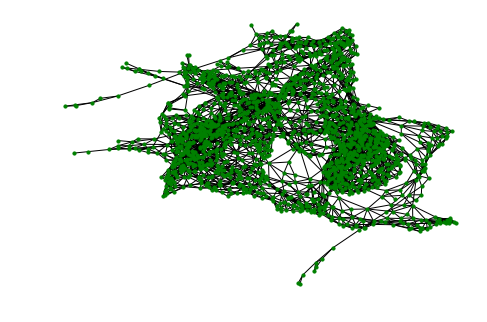

In [16]:
import matplotlib.pyplot as plt 
# pointIDXY = dict(zip(range(len(points)), points)) 
# pointIDXY = dict(zip(range(len(largest_g1.nodes)), largest_g1.nodes))
# nx.draw(graph1,node_size = 10, node_color = "blue") 
# plt.show() 

# pointIDXY = dict(zip(range(len(filtered_points)), filtered_points)) 
nx.draw(largest_g2,node_size = 10, node_color = "green") 
plt.show()

In [17]:
nx.set_edge_attributes(largest_g2, traffic_flows, 'capacity')

In [18]:
print(len(edges))

10810


In [19]:
for (u,v) in largest_g2.edges:
    print(u,v)
    print(largest_g2[u][v])
    if v!=643: break

(1, 1732)
{'capacity': 1604.7323274807727}


#### Q13 Calculate the Max Flow & Calculate the Number of Edge-Disjoint Paths


In [20]:
stanford_id = 2606
UCSC_id = 1967
print(nx.maximum_flow_value(largest_g2, stanford_id, UCSC_id))

from networkx.algorithms.connectivity.disjoint_paths import edge_disjoint_paths
print(len(list(edge_disjoint_paths(largest_g2, stanford_id, UCSC_id))))

8108.9785486
5


#### Q14 Defoliate the Graph

In [ ]:
threshold = 20
ebunch = []
for (u,v) in largest_g2.edges():
    if largest_g2[u][v]['weight'] < threshold:
        ebunch.append((u,v))
        
largest_g2.remove_edges_from(ebunch)
# largest_g2.__dict__
# plot on real map coordinates and check bridges location

#### Q15: triangle inequality